# State Distribution Example

In this example, we plan to plot the distribution of system states. This helps researchers on serverless computing platforms to debug and test out their performance models with knowledge of system state distribution.

In [1]:
# imports

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from pacssim.ServerlessSimulator import ServerlessSimulator as Sim

sim = Sim(arrival_rate=0.9, warm_service_rate=1/1.991, cold_service_rate=1/2.244,
            expiration_threshold=600, max_time=100000)
sim.generate_trace(debug_print=False)
sim.print_trace_results()

Cold Starts / total requests: 	 143 / 90220
Cold Start Probability: 	 0.0016
Rejection / total requests: 	 0 / 90220
Rejection Probability: 		 0.0000
Average Instance Life Span: 	 5573.1401
Average Server Count:  		 7.8489
Average Running Count:  	 1.7922
Average Idle Count:  		 6.0567


You can define any state representation you want based on the data present in the trace.
Here, we chose to use the number of servers as state.

In [6]:
sim.calculate_time_lengths()

# encode states
hist_states = []
for idx in range(len(sim.hist_server_count)):
    if sim.hist_server_count[idx] == 0:
        hist_states.append((0, 'd'))
    else:
        curr_server_count = sim.hist_server_count[idx]
        prev_server_count = sim.hist_server_count[idx-1]
        if curr_server_count > prev_server_count:
            hist_states.append((curr_server_count, 'u'))
        elif curr_server_count < prev_server_count:
            hist_states.append((curr_server_count, 'd'))
        else: # state hasn't changed
            hist_states.append(hist_states[-1])

vals, probs = sim.calculate_time_average(hist_states, skip_init_time=100)
# sim.print_time_average(vals, probs)
residence_time_avgs = sim.get_average_residence_times(hist_states, skip_init_time=100)
residence_time_list = [residence_time_avgs[s] for s in vals]
df = pd.DataFrame(data = {'state': vals, 'prob': probs, 'sojourn_time': residence_time_list})
df = df.sort_values(by='state')
df

,state,prob,sojourn_time
10,"(5, u)",0.000589,58.837697
4,"(6, d)",0.051031,170.982876
3,"(6, u)",0.000453,45.240808
1,"(7, d)",0.235759,373.846063
9,"(7, u)",0.106367,354.202443
2,"(8, d)",0.045250,145.821335
8,"(8, u)",0.339970,539.093913
0,"(9, d)",0.004918,49.126349
6,"(9, u)",0.155492,501.084151
7,"(10, d)",0.000018,0.596963


## Calculate Average Transition Times

In [33]:
residence_times, transition_times = sim.analyze_custom_states(hist_states, skip_init_time=100)
transition_counts = {}
for k in transition_times:
    transition_counts[k] = len(transition_times[k])

t_starts = [s[0] for s in transition_counts.keys()]
t_ends = [s[1] for s in transition_counts.keys()]
t_counts = [transition_counts[k] for k in transition_counts.keys()]
t_avgs = [np.mean(transition_times[s]) for s in transition_counts.keys()]

df = pd.DataFrame(data = {'start': t_starts, 'end': t_ends, 'count': t_counts, 'average': t_avgs})

t_totals = [df.loc[df['start'] == k[0], 'count'].sum() for k in transition_counts.keys()]
df['totals'] = t_totals
df['prob'] = df['count'] / df['totals']

df = df.sort_values(by='start')
df

,start,end,count,average,totals,prob
0,"(5, u)","(6, u)",1,58.837697,1,1.000000
8,"(6, d)","(7, u)",29,170.982876,29,1.000000
1,"(6, u)","(7, u)",1,45.240808,1,1.000000
6,"(7, d)","(8, u)",34,495.894551,63,0.539683
7,"(7, d)","(6, d)",29,230.754733,63,0.460317
2,"(7, u)","(8, u)",29,279.879026,30,0.966667
16,"(7, u)","(6, d)",1,2509.581517,30,0.033333
5,"(8, d)","(7, d)",30,111.960229,31,0.967742
17,"(8, d)","(9, u)",1,1161.654542,31,0.032258
3,"(8, u)","(9, u)",30,298.329012,63,0.476190


## Calculate Time Average of Server Count

Value           Prob
5               0.0006
6               0.0515
7               0.3421
8               0.3852
9               0.1604
10              0.0421
11              0.0180


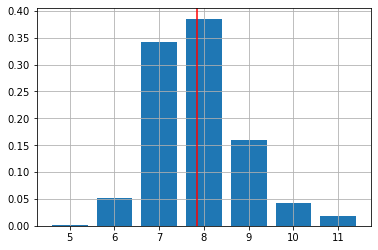

In [4]:
sim.calculate_time_lengths()

unq_vals, val_times = sim.calculate_time_average(sim.hist_server_count, skip_init_time=100)

plt.bar(unq_vals, val_times)
plt.grid(True)
plt.axvline(x=sim.get_average_server_count(), c='r')

sim.print_time_average(unq_vals, val_times)

In [5]:
pd.DataFrame(data = {'server_count': unq_vals, 'Probability': val_times}).sort_values('server_count')

,server_count,Probability
0,5,0.000589
1,6,0.051484
2,7,0.342127
3,8,0.385220
4,9,0.160409
5,10,0.042131
6,11,0.018040
